In [1]:
import tensorflow as tf
from tensorflow.keras import layers, losses
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Lambda
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard
import os
from glob2 import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import time
from time import time
import matplotlib.pyplot as plt
from PIL import Image, ImageChops, ImageStat
from diffimg import diff
from sklearn.model_selection import train_test_split

In [2]:
from skimage.feature import graycomatrix, graycoprops
from skimage import filters

# Statistics approach 統計學方法

In [3]:
def findImageDefects(input_image):
    
    
    # 對圖像進行對比度增強
    image_alpha = cv2.convertScaleAbs(input_image, alpha=1.2, beta=0)
    # 將圖像轉換為灰度圖
    gray_image = cv2.cvtColor(image_alpha, cv2.COLOR_BGR2GRAY)
    detect_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2GRAY)
    
    # 高斯模糊
    image = cv2.GaussianBlur(gray_image, (17, 17), 0) # 用來統計的圖像
    detect_image = cv2.GaussianBlur(detect_image, (17, 17), 0) # 用來輸出偵測結果
    
    # 複製圖像
    output_image = np.copy(input_image) # 用來比較原圖
    
    
    size_filter = 25 # 25
    nr,nc = image.shape[:2]
    #print(nr,nc)

    offset = 5
    x_filter = int((nr)/offset)
    y_filter = int((nc)/offset)
    
    co_correlation = np.zeros((x_filter ,y_filter))
    co_homogeneity = np.zeros((x_filter ,y_filter))
    co_contrast = np.zeros((x_filter ,y_filter))

    end_r = nr - size_filter + offset
    end_c = nc - size_filter + offset

    for i in range(0, end_r, offset):
        for j in range(0, end_c, offset):
            
            f = image[ i : i + size_filter , j : j + size_filter ]
            result = graycomatrix( f, [1],[0] )
            co_correlation[int(i/offset),int(j/offset)] = float(graycoprops(result, 'correlation'))
            co_homogeneity[int(i/offset),int(j/offset)] = float(graycoprops(result, 'homogeneity'))
            co_contrast[int(i/offset),int(j/offset)] = float(graycoprops(result, 'contrast'))
    
    correlation_mean = np.mean(co_correlation)
    homogeneity_mean = np.mean(co_homogeneity)
    contrast_mean = np.mean(co_contrast)
    
    threshold_correlation = correlation_mean * 1.0975
    threshold_homogeneity = homogeneity_mean * 0.725
    threshold_contrast = contrast_mean * 0.975
    
    defects = np.zeros( [ x_filter, y_filter ] )
    
    # 標記空洞位置
    for i in range(x_filter):
        for j in range(y_filter):
            if co_correlation[i,j] > threshold_correlation:
                #cv2.circle(image,( j*offset , i*offset ), 1, (255,0,0), -1)
                if (co_contrast[i,j] > threshold_contrast):
                    defects[i, j] = 1
                elif (co_homogeneity[i,j] <= threshold_homogeneity):
                    defects[i, j] = 1
    
    for i in range(x_filter):
        for j in range(y_filter):
            if defects[i, j]:
                # 檢查周圍
                transposed_defects = defects.T
                
                pixels_x = defects[i][j-2:j+3]
                #x_count_0 = np.count_nonzero(pixels_x==0)
                x_count_1 = np.count_nonzero(pixels_x)
                
                pixels_y = transposed_defects[j][i-2:i+3]
                #y_count_0 = np.count_nonzero(pixels_y==0)
                y_count_1 = np.count_nonzero(pixels_y)
                
                if x_count_1 + y_count_1 > 9:
                    cv2.circle(detect_image,( j*offset , i*offset ), 25, (255,0,0), -1)
                    cv2.circle(output_image,( j*offset , i*offset ), 25, (255,255,255), -1)
                if x_count_1 > 3:
                    cv2.ellipse(detect_image,( j*offset , i*offset ),( 48 , 24 ), 0, 0, 360, (255,0,0), -1)
                    cv2.ellipse(output_image,( j*offset , i*offset ),( 48 , 24 ), 0, 0, 360, (255,255,255), -1)
                if y_count_1 > 3:
                    cv2.ellipse(detect_image,( j*offset , i*offset ),( 24 , 48 ), 0, 0, 360, (255,0,0), -1)
                    cv2.ellipse(output_image,( j*offset , i*offset ),( 24 , 48 ), 0, 0, 360, (255,255,255), -1)
    
    return detect_image, output_image

In [4]:
def DefectDetection(input_image):
    _, detect_image = cv2.threshold(input_image, 127, 255, cv2.THRESH_BINARY_INV)
    
    background_pixels = 800 * 600
    
    # 使用 numpy 的 nonzero 函數獲取輸出圖像中所有非零像素的位置
    black_pixels = np.nonzero(detect_image)
    # 從 black_pixels 中提取出黑色區塊
    black_region = detect_image[black_pixels]
    
    # 使用 numpy 的 count_nonzero 函數計算 black_region 中黑色像素的數量
    num_black_pixels = np.count_nonzero(black_region)

    # print('defect size:', background_pixels - num_black_pixels)
    
    hasDefect = False
    
    if background_pixels - num_black_pixels > 1000:
        hasDefect = True
    else:
        detect_image[black_pixels] = 255
        hasDefect = False
        
    return hasDefect, detect_image

In [5]:
def images_display(img1, img2, img3):
    # 建立一個大小為 3x1 的圖表矩陣，並傳回 Figure 和 Axes 物件
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))

    # 繪製第一張圖
    axs[0].imshow(img1, cmap='gray')
    axs[0].set_title('Input image')

    # 繪製第二張圖
    axs[1].imshow(img2, cmap='gray')
    axs[1].set_title('Output image')

    # 繪製第三張圖
    axs[2].imshow(img3, cmap='binary_r')
    axs[2].set_title('Detection image')

    plt.show()

# 測試資料偵測瑕疵

In [6]:
import cv2
import tensorflow as tf
import numpy as np
from os import listdir
from os.path import join
import time

img-0 cost time : 13.180416822433472 sec


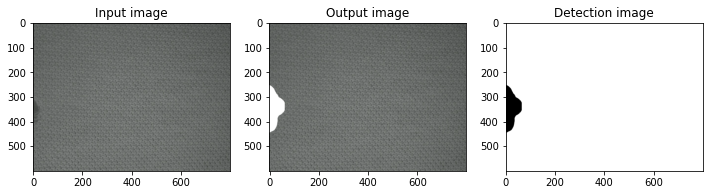

0.009653401416122004
This image has a defect.

img-1 cost time : 13.345038175582886 sec


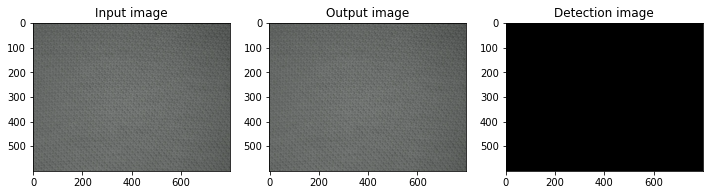

0.0
This image has no defect

img-2 cost time : 13.046952247619629 sec


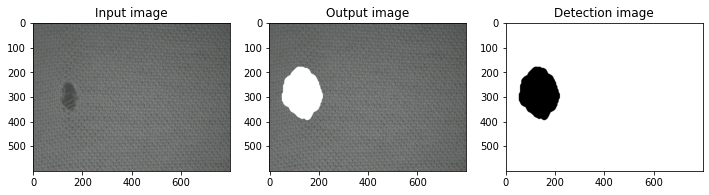

0.03183181917211329
This image has a defect.



In [7]:
if __name__ == '__main__':
    fld = './error/'
    for i, f in enumerate(listdir(fld)):
        
        frame = cv2.imread(join(fld, f))
        
        time_start = time.time()
        detect_image, output_image = findImageDefects(frame)
        time_end = time.time()
        print(f'img-{i} cost time : {time_end - time_start} sec')
        
        cv2.imwrite(f'./statistics_error_result/result{i}.png', output_image)
        
        hasDefect, detect_image = DefectDetection(detect_image)
        
        cv2.imwrite( f'./statistics_error_detect/result{i}.png', detect_image)
        
        images_display(frame, output_image, detect_image)
        
        img1= join(fld, f)
        img2= f'./statistics_error_result/result{i}.png'
        
        difference = diff(img1,img2)
        print(difference)
        
        if difference > 0.0 and hasDefect:
            print("This image has a defect.\n")
        else:
            print("This image has no defect\n")

In [8]:
# 錯誤比對函數 diff()
img1="statistics_error_result/result1.png"
img2="error/img1 copy.jpg"
print(diff(img1,img2))

0.0
